<a href="https://colab.research.google.com/github/Shemonti/Code_Matcher/blob/master/intrusion_detection_system_DL(kddcup).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

import requests
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

In [ ]:
# Due to memory allocation limit we are using 10 percent of actual dataset
url1 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/kddcup99-mld/kddcup.data.gz'
url2 =  'https://archive.ics.uci.edu/ml/machine-learning-databases/kddcup99-mld/kddcup.data_10_percent.gz'

file_name1 = 'kddcup.data.gz'
file_name2 = 'kddcup.data_10_percent.gz'
data_path = tf.keras.utils.get_file(file_name2, origin=url2)

print(data_path)

2154496/2144903 [==============================] - 0s 0us/step
/root/.keras/datasets/kddcup.data_10_percent.gz


In [ ]:
df = pd.read_csv(data_path, header= None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,9,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,19,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,29,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,39,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,49,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,tcp,http,SF,310,1881,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,5,0.00,0.00,0.0,0.0,1.0,0.0,0.40,86,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,282,2286,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,6,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,203,1200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,18,0.17,0.11,0.0,0.0,1.0,0.0,0.17,16,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,291,1200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,12,0.00,0.00,0.0,0.0,1.0,0.0,0.17,26,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [ ]:
names_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/kddcup99-mld/kddcup.names'
f1 = requests.get(names_url)
print(f1.text)

back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,nmap,normal,perl,phf,pod,portsweep,rootkit,satan,smurf,spy,teardrop,warezclient,warezmaster.
duration: continuous.
protocol_type: symbolic.
service: symbolic.
flag: symbolic.
src_bytes: continuous.
dst_bytes: continuous.
land: symbolic.
wrong_fragment: continuous.
urgent: continuous.
hot: continuous.
num_failed_logins: continuous.
logged_in: symbolic.
num_compromised: continuous.
root_shell: continuous.
su_attempted: continuous.
num_root: continuous.
num_file_creations: continuous.
num_shells: continuous.
num_access_files: continuous.
num_outbound_cmds: continuous.
is_host_login: symbolic.
is_guest_login: symbolic.
count: continuous.
srv_count: continuous.
serror_rate: continuous.
srv_serror_rate: continuous.
rerror_rate: continuous.
srv_rerror_rate: continuous.
same_srv_rate: continuous.
diff_srv_rate: continuous.
srv_diff_host_rate: continuous.
dst_host_count: continuous.
dst_host_srv_count: con

In [ ]:
attack_types = 'https://archive.ics.uci.edu/ml/machine-learning-databases/kddcup99-mld/training_attack_types'
types = requests.get(attack_types)
print(types.text)

back dos
buffer_overflow u2r
ftp_write r2l
guess_passwd r2l
imap r2l
ipsweep probe
land dos
loadmodule u2r
multihop r2l
neptune dos
nmap probe
perl u2r
phf r2l
pod dos
portsweep probe
rootkit u2r
satan probe
smurf dos
spy r2l
teardrop dos
warezclient r2l
warezmaster r2l




In [ ]:
# Target types data extraction
attack_dict = {}
types_text_split = types.text.split()
for idx in range(0, len(types_text_split)):
    if idx < len(types_text_split) -1:
      attack_dict[types_text_split[idx]] = types_text_split[idx+1]
attack_dict['normal'] = 'normal'
attack_dict

{'back': 'dos',
 'buffer_overflow': 'u2r',
 'dos': 'warezclient',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'imap': 'r2l',
 'ipsweep': 'probe',
 'land': 'dos',
 'loadmodule': 'u2r',
 'multihop': 'r2l',
 'neptune': 'dos',
 'nmap': 'probe',
 'normal': 'normal',
 'perl': 'u2r',
 'phf': 'r2l',
 'pod': 'dos',
 'portsweep': 'probe',
 'probe': 'smurf',
 'r2l': 'warezmaster',
 'rootkit': 'u2r',
 'satan': 'probe',
 'smurf': 'dos',
 'spy': 'r2l',
 'teardrop': 'dos',
 'u2r': 'satan',
 'warezclient': 'r2l',
 'warezmaster': 'r2l'}

In [ ]:
# extract column names from .names file
col_names = []
f1_text_split = f1.text.split('\n')
for idx in range(1, len(f1_text_split)):
  col_name = f1_text_split[idx].split(':')[0]
  if idx == len(f1_text_split)-1:
    col_name = 'target'
  col_names.append(col_name)
col_names

['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'target']

In [ ]:
# assign the actual columns to the dataframe
df.columns = col_names
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,9,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,19,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,29,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,39,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,49,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,tcp,http,SF,310,1881,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,5,0.00,0.00,0.0,0.0,1.0,0.0,0.40,86,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,282,2286,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,6,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,203,1200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,18,0.17,0.11,0.0,0.0,1.0,0.0,0.17,16,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,291,1200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,12,0.00,0.00,0.0,0.0,1.0,0.0,0.17,26,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [ ]:
# map actual type to another column called 'target_type'
df['target_type'] = df.target.apply(lambda x : attack_dict[x[0:-1]] )
df.target_type.value_counts()

dos       391458
normal     97278
probe       4107
r2l         1126
u2r           52
Name: target_type, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   land                         494021 non-null  int64  
 7   wrong_fragment               494021 non-null  int64  
 8   urgent                       494021 non-null  int64  
 9   hot                          494021 non-null  int64  
 10  num_failed_logins            494021 non-null  int64  
 11  logged_in                    494021 non-null  int64  
 12  num_compromised              494021 non-null  int64  
 13 

In [ ]:
# Identifying categorical features
numeric_cols = df._get_numeric_data().columns # gets all the numeric column names

categorical_cols = list(set(df.columns)-set(numeric_cols))
categorical_cols

['protocol_type', 'service', 'target_type', 'flag', 'target']

In [ ]:
# lets look into deeply to identify if there are any other binary data exists or not
binary_cols = []
for col in numeric_cols:
  if len(df[col].unique()) <= 2:
      result = []
      s = df[col].value_counts()
      t = float(len(df[col]))
      for v in s.index:
          result.append("{}({}%)".format(v,round(100*(s[v]/t),1)))
      print("{} - [{}]".format(col, " , ".join(result)))
      binary_cols.append(col)

land - [0(100.0%) , 1(0.0%)]
logged_in - [0(85.2%) , 1(14.8%)]
root_shell - [0(100.0%) , 1(0.0%)]
num_outbound_cmds - [0(100.0%)]
is_host_login - [0(100.0%)]
is_guest_login - [0(99.9%) , 1(0.1%)]


In [ ]:
# combine all categorical column names
for col in binary_cols:
  categorical_cols.append(col)
categorical_cols

['protocol_type',
 'service',
 'target_type',
 'flag',
 'target',
 'land',
 'logged_in',
 'root_shell',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login']

In [ ]:
# identify remaining numeric features by subtracting categorical columns
numeric_features = list(set(numeric_cols)-set(categorical_cols))
numeric_features

['dst_host_same_src_port_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_serror_rate',
 'dst_host_rerror_rate',
 'srv_count',
 'dst_host_same_srv_rate',
 'srv_serror_rate',
 'dst_host_diff_srv_rate',
 'dst_host_srv_rerror_rate',
 'hot',
 'dst_bytes',
 'dst_host_count',
 'rerror_rate',
 'dst_host_srv_diff_host_rate',
 'wrong_fragment',
 'srv_diff_host_rate',
 'duration',
 'srv_rerror_rate',
 'num_access_files',
 'num_compromised',
 'dst_host_srv_serror_rate',
 'su_attempted',
 'num_shells',
 'num_failed_logins',
 'num_file_creations',
 'src_bytes',
 'num_root',
 'serror_rate',
 'urgent',
 'dst_host_srv_count',
 'count']

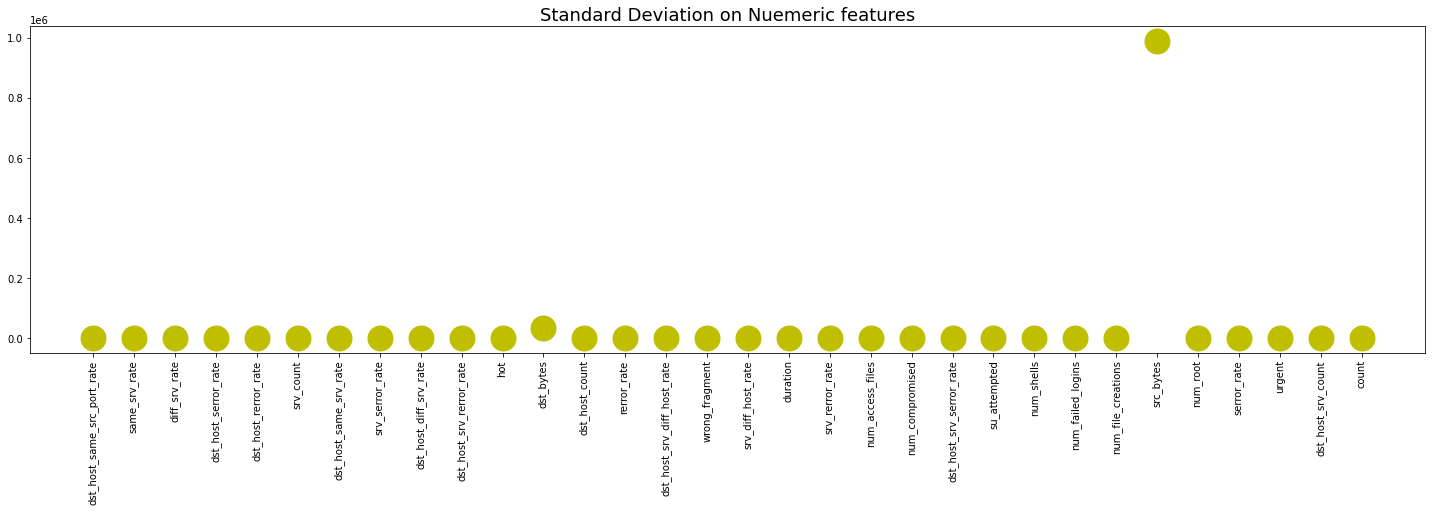

In [ ]:
def plot_std_dist(_title):
  df_std = df[numeric_features].std()
  plt.figure(figsize=(25,6))
  plt.plot(list(df_std.index) ,list(df_std.values), 'yo', markersize=25)
  plt.xticks(rotation=90)
  plt.title(_title, fontsize= 18)
  plt.show()

plot_std_dist('Standard Deviation on Nuemeric features')

In [ ]:
def apply_zscore(feature):
  mean = df[feature].mean()
  std = df[feature].std()
  df[feature] = (df[feature] - mean) / std

for feature in numeric_features:
  apply_zscore(feature)

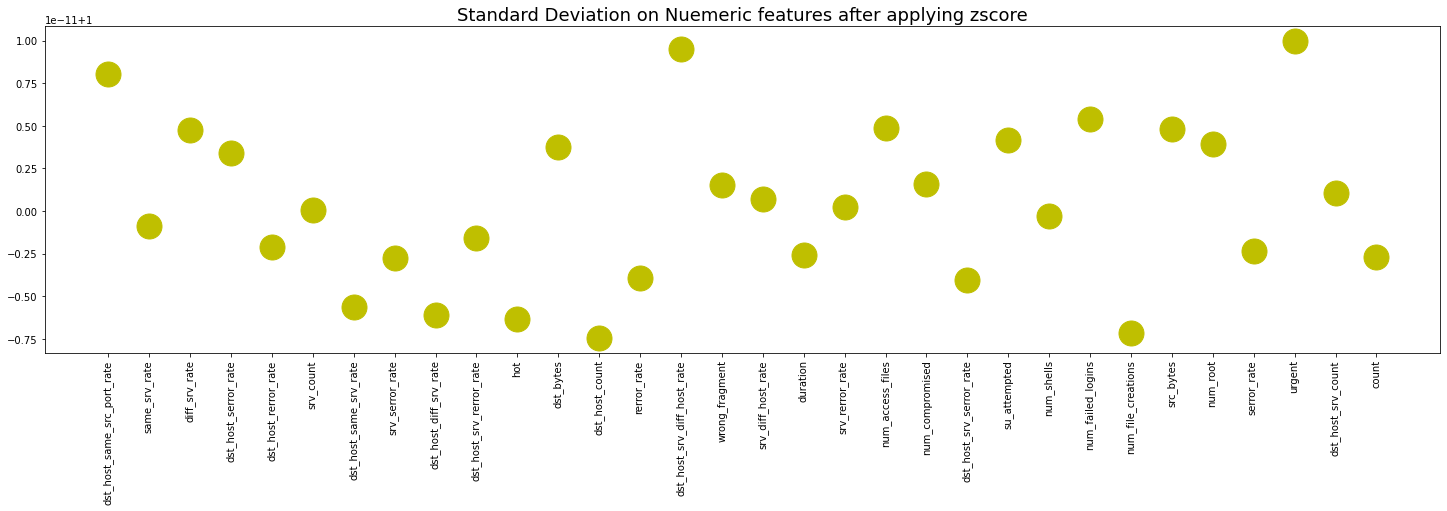

In [ ]:
plot_std_dist('Standard Deviation on Nuemeric features after applying zscore')

In [ ]:
def apply_dummies(df, feature):
    get_dummies = pd.get_dummies(df[feature])
    for x in get_dummies.columns:
        dummy_name = f"{feature}-{x}"
        df[dummy_name] = get_dummies[x]
    df.drop(feature, axis=1, inplace=True)
    return None

In [ ]:
# apply one hot encoding for categorical columns except the target and target_types
for feature in categorical_cols:
  if feature not in ['target', 'target_type']:
    apply_dummies(df, feature)

In [ ]:
df

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,su_attempted,num_root,num_file_creations,num_shells,num_access_files,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,target_type,protocol_type-icmp,protocol_type-tcp,protocol_type-udp,service-IRC,service-X11,service-Z39_50,...,service-remote_job,service-rje,service-shell,service-smtp,service-sql_net,service-ssh,service-sunrpc,service-supdup,service-systat,service-telnet,service-tftp_u,service-tim_i,service-time,service-urh_i,service-urp_i,service-uucp,service-uucp_path,service-vmnet,service-whois,flag-OTH,flag-REJ,flag-RSTO,flag-RSTOS0,flag-RSTR,flag-S0,flag-S1,flag-S2,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,root_shell-0,root_shell-1,num_outbound_cmds-0,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.004676,-0.00564,-0.011232,-0.009919,-0.027632,-1.521415,-1.156639,-0.464089,-0.463520,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-3.451532,-1.694313,0.599396,-0.282866,-1.022076,-0.158629,-0.464417,-0.463202,-0.252039,-0.249464,normal.,normal,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,1,1,0
1,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.004676,-0.00564,-0.011232,-0.009919,-0.027632,-1.521415,-1.156639,-0.464089,-0.463520,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-3.297081,-1.600009,0.599396,-0.282866,-1.146736,-0.158629,-0.464417,-0.463202,-0.252039,-0.249464,normal.,normal,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,1,1,0
2,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.004676,-0.00564,-0.011232,-0.009919,-0.027632,-1.521415,-1.156639,-0.464089,-0.463520,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-3.142630,-1.505706,0.599396,-0.282866,-1.188290,-0.158629,-0.464417,-0.463202,-0.252039,-0.249464,normal.,normal,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,1,1,0
3,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.004676,-0.00564,-0.011232,-0.009919,-0.027632,-1.530798,-1.164758,-0.464089,-0.463520,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-2.988179,-1.411402,0.599396,-0.282866,-1.188290,-0.158629,-0.464417,-0.463202,-0.252039,-0.249464,normal.,normal,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,1,1,0
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.004676,-0.00564,-0.011232,-0.009919,-0.027632,-1.530798,-1.164758,-0.464089,-0.463520,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-2.833728,-1.317098,0.599396,-0.282866,-1.209066,-0.158629,-0.464417,-0.463202,-0.252039,-0.249464,normal.,normal,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,-0.067792,-0.002748,0.030644,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.004676,-0.00564,-0.011232,-0.009919,-0.027632,-1.540181,-1.168818,-0.464089,-0.463520,-0.24796,-0.248631,0.536987,-0.255243,2.605406,-2.262258,0.625557,0.599396,-0.282866,-1.229843,1.028093,-0.464417,-0.436950,-0.252039,-0.249464,normal.,normal,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1

In [ ]:
# convert to numpy arrays
x_features = df.columns.drop(['target','target_type'])
x = df[x_features].values
print('Shape of Independent features data : ' + str(x.shape))
target_type_dummies = pd.get_dummies(df['target_type']) # Multi Class Classification (tartget_type is grouped attack types)
target = target_type_dummies.columns
num_classes = len(target)
y = target_type_dummies.values
print('Shape of Dependent features data : ' + str(y.shape))

Shape of Independent features data : (494021, 122)
Shape of Dependent features data : (494021, 5)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=101)
print('Shape of Independent features Train data : ' + str(X_train.shape))
print('Shape of Dependent features Train data : ' + str(y_train.shape))
print('Shape of Independent features Test data: ' + str(X_test.shape))
print('Shape of Dependent features Test data: ' + str(y_test.shape))

Shape of Independent features Train data : (395216, 122)
Shape of Dependent features Train data : (395216, 5)
Shape of Independent features Test data: (98805, 122)
Shape of Dependent features Test data: (98805, 5)


In [ ]:
# create model with most common parameters 
def seq_model():
    model = Sequential()
    model.add(Dense(x.shape[1],input_dim =x.shape[1],activation = 'relu',kernel_initializer='random_uniform'))
    model.add(Dropout(0.01))
    model.add(Dense(61,activation='relu',kernel_initializer='random_uniform'))
    model.add(Dropout(0.01))
    model.add(Dense(30,activation='relu',kernel_initializer='random_uniform'))
    model.add(Dropout(0.01))
    model.add(Dense(15,activation='relu',kernel_initializer='random_uniform'))
    model.add(Dropout(0.01))
    model.add(Dense(y.shape[1],activation='softmax'))   
    return model

In [ ]:
def evaluate_model(model):
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    return None

In [ ]:
def plot_results(history, optimizer, loss_fun):
    plt.figure(figsize=(25,6))
    # plot loss during training
    plt.subplot(121)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    # plot accuracy during training
    plt.subplot(122)
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.suptitle(f"{optimizer} Optimizer with {loss_fun} as Loss function", fontsize= 23)
    plt.show()
    return None

Epoch 1/50
12351/12351 - 27s - loss: 0.0170 - accuracy: 0.9962 - val_loss: 0.0057 - val_accuracy: 0.9988 - 27s/epoch - 2ms/step
Epoch 2/50
12351/12351 - 26s - loss: 0.0044 - accuracy: 0.9990 - val_loss: 0.0040 - val_accuracy: 0.9991 - 26s/epoch - 2ms/step
Epoch 3/50
12351/12351 - 26s - loss: 0.0054 - accuracy: 0.9991 - val_loss: 0.0030 - val_accuracy: 0.9992 - 26s/epoch - 2ms/step
Epoch 4/50
12351/12351 - 23s - loss: 0.0056 - accuracy: 0.9992 - val_loss: 0.0027 - val_accuracy: 0.9993 - 23s/epoch - 2ms/step
Epoch 5/50
12351/12351 - 24s - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.0030 - val_accuracy: 0.9993 - 24s/epoch - 2ms/step
Epoch 6/50
12351/12351 - 24s - loss: 0.0079 - accuracy: 0.9992 - val_loss: 0.0028 - val_accuracy: 0.9993 - 24s/epoch - 2ms/step
Epoch 7/50
12351/12351 - 26s - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.0030 - val_accuracy: 0.9993 - 26s/epoch - 2ms/step
Epoch 8/50
12351/12351 - 24s - loss: 0.0057 - accuracy: 0.9993 - val_loss: 0.0026 - val_accuracy: 0.9994

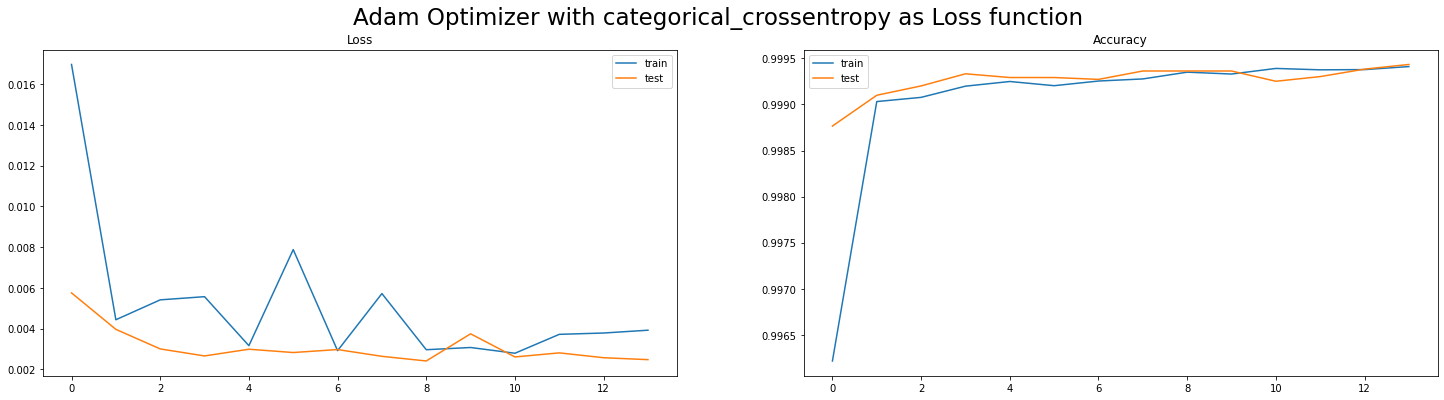

In [ ]:
# model with crossentropy loss and adam optimizer
model = seq_model()
model.compile(loss ='categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),callbacks=[monitor],verbose=2,epochs=50)
evaluate_model(model)
plot_results(history, 'Adam', 'categorical_crossentropy')

Epoch 1/50
12351/12351 - 28s - loss: 0.0065 - accuracy: 0.9957 - val_loss: 0.0016 - val_accuracy: 0.9991 - 28s/epoch - 2ms/step
Epoch 2/50
12351/12351 - 27s - loss: 0.0017 - accuracy: 0.9991 - val_loss: 0.0015 - val_accuracy: 0.9990 - 27s/epoch - 2ms/step
Epoch 3/50
12351/12351 - 25s - loss: 0.0016 - accuracy: 0.9992 - val_loss: 0.0016 - val_accuracy: 0.9991 - 25s/epoch - 2ms/step
Epoch 4/50
12351/12351 - 25s - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.0025 - val_accuracy: 0.9989 - 25s/epoch - 2ms/step
Epoch 5/50
12351/12351 - 27s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0011 - val_accuracy: 0.9994 - 27s/epoch - 2ms/step
Epoch 6/50
12351/12351 - 27s - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.0013 - val_accuracy: 0.9993 - 27s/epoch - 2ms/step
Epoch 7/50
12351/12351 - 27s - loss: 0.0015 - accuracy: 0.9994 - val_loss: 0.0011 - val_accuracy: 0.9994 - 27s/epoch - 2ms/step
Epoch 8/50
12351/12351 - 27s - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0016 - val_accuracy: 0.9993

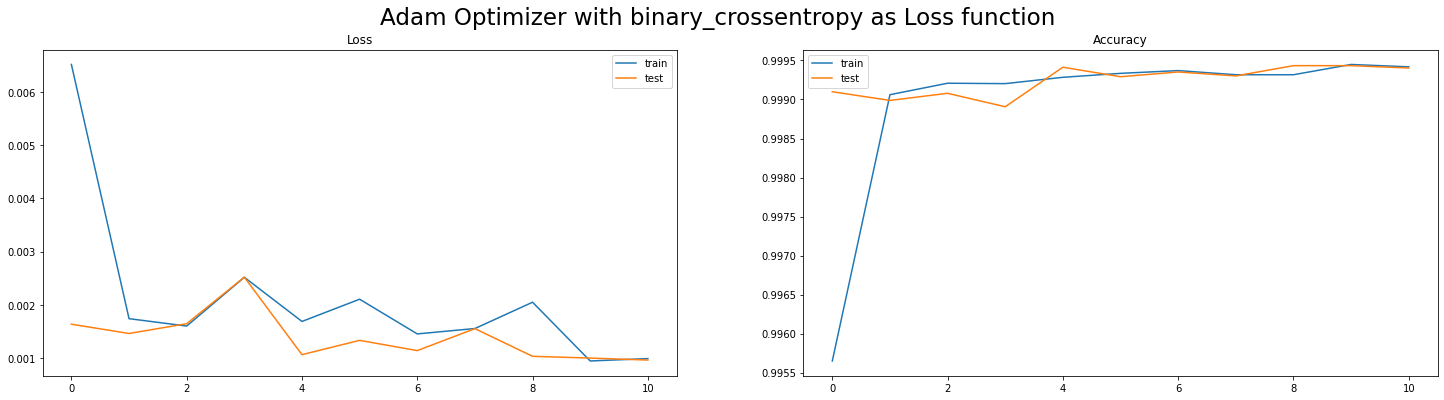

In [ ]:
# model with crossentropy loss and adam optimizer
model = seq_model()
model.compile(loss ='binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),callbacks=[monitor],verbose=2,epochs=50)
evaluate_model(model)
plot_results(history, 'Adam', 'binary_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
12351/12351 - 20s - loss: 0.0348 - accuracy: 0.9898 - val_loss: 0.0059 - val_accuracy: 0.9986 - 20s/epoch - 2ms/step
Epoch 2/50
12351/12351 - 19s - loss: 0.0069 - accuracy: 0.9983 - val_loss: 0.0045 - val_accuracy: 0.9989 - 19s/epoch - 2ms/step
Epoch 3/50
12351/12351 - 21s - loss: 0.0192 - accuracy: 0.9968 - val_loss: 0.0054 - val_accuracy: 0.9987 - 21s/epoch - 2ms/step
Epoch 4/50
12351/12351 - 19s - loss: 0.0169 - accuracy: 0.9976 - val_loss: 0.0120 - val_accuracy: 0.9960 - 19s/epoch - 2ms/step
Epoch 5/50
12351/12351 - 21s - loss: 0.0575 - accuracy: 0.9902 - val_loss: 0.0138 - val_accuracy: 0.9975 - 21s/epoch - 2ms/step
Epoch 6/50
12351/12351 - 21s - loss: 0.5878 - accuracy: 0.8318 - val_loss: 0.5624 - val_accuracy: 0.7909 - 21s/epoch - 2ms/step
Epoch 7/50
12351/12351 - 21s - loss: 0.5588 - accuracy: 0.7927 - val_loss: 0.5622 - val_accuracy: 0.7909 - 21s/epoch - 2ms/step
Epoch 8/50
12351/12351 - 21s - loss: 0.5586 - accuracy: 0.7928 - val_loss: 0.5623 - val_accuracy: 0.7909

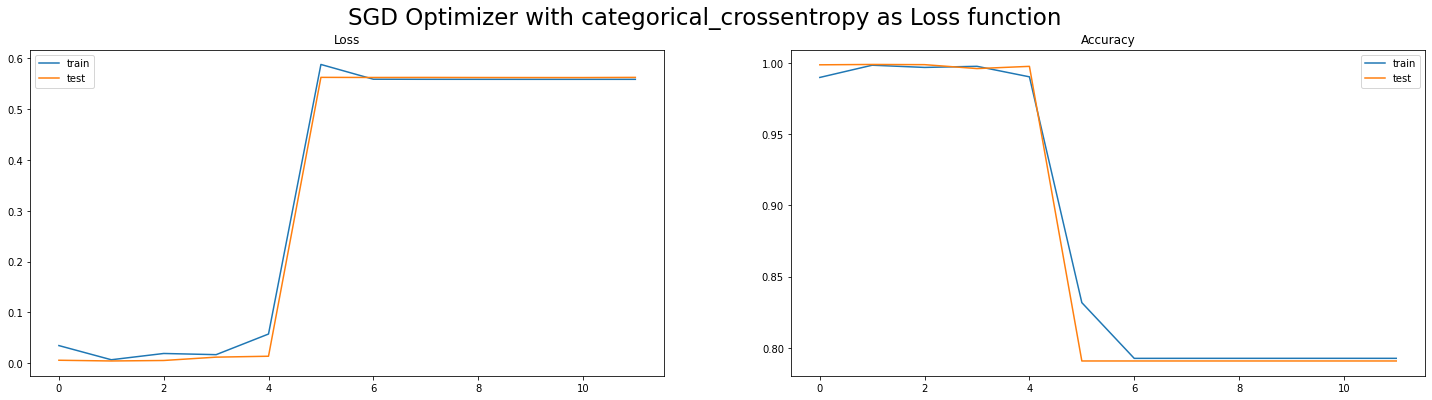

In [ ]:
# model with crossentropy loss and SGD optimizer
model = seq_model()
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss ='categorical_crossentropy',optimizer = opt,metrics = ['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),callbacks=[monitor],verbose=2,epochs=50)
evaluate_model(model)
plot_results(history, 'SGD', 'categorical_crossentropy')